# Consensus WBF

In [1]:
import os

from utils.metrics import create_plots
from utils.consensus_WBF import calculate_consensus_focus, ensemble_reweight, weighted_boxes_fusion, convert_darknet, toDarknet

## Directory structure

We declare a base path to store the inferences on the target domain from every source network. They all must have the same number of text files. The directory structure should be as follows:

```
base_path
│       
└───labels
│   │   model1
│       │   inference_darknet_format_1.txt
│       │   inference_darknet_format_2.txt
|       |   inference_darknet_format_3.txt
│       │   ...
│   │   model2
│       │   inference_darknet_format_1.txt
│       │   inference_darknet_format_2.txt
|       |   inference_darknet_format_3.txt
│       │   ...
│   │   model3
│       │   inference_darknet_format_1.txt
│       │   inference_darknet_format_2.txt
|       |   inference_darknet_format_3.txt
│       │   ...
|   |   modeln
|       |   ...
```

In [2]:
!ls inputs/labels

model1	model2	model3


In [3]:
iou_thr = 0.55
skip_box_thr=20*[0.95]
skip_box_thr[2]=0.8 #biaozhunliewen
skip_box_thr[4]=0.862878445549029 #duocengmian
skip_box_thr[8]=0.949615906009941 #molengliangke
skip_box_thr[9]=0.949661093538183 #pingmianbengque
skip_box_thr[13]=0.93689561680976 #xixiaoliewen 
skip_box_thr[14]=0.927699954812472 #zazhi
initial_weights = [1,1,1] ##Initial weights
m_folder="inputs/labels"
conf_type='avg'

## Consensus focus for object detection

The consensus quality for object detection is the sum of the product between the number of models supporting a fused bounding box in a source dataset subset $S' \subseteq S$. Here, we denote $S = \left\{ D^{(i)} \right\}^{I}_{i=1}$ as a set of source datasets and $Q\left( S' \right)$ is the consensus quality of a subset of $S$:

$$
Q(S')=\sum_{x^{T}_{j} \epsilon X^{(T)}}\sum_{b_{j} \epsilon B_{j}}n_{b_j}(S')p_{b_j}(S')
$$

The consensus focus $CF\left( D^{(i)} \right)$ quantifies the contribution of each source domain through the surveys based on measuring the total consensus quality of all combinations between the elements of $S$. In other words, the CF designates the marginal contribution of the single source domain $D^{(i)}$ to the consensus quality of all source domains $S$.

$$
CF\left( D^{(i)}\right)=Q\left(S \right)-Q\left( S\smallsetminus D^{(i)} \right)
$$

In [4]:
consensus_focus_dict=calculate_consensus_focus(m_folder=m_folder, skip_box_thr=skip_box_thr, initial_weights=initial_weights, iou_thr=iou_thr,conf_type=conf_type)
print(consensus_focus_dict)

{1: 82.52553896228243, 2: 123.31216138006421, 3: 41.863310595319945}


### **Case I**. Ensembling of multiple models.
It indicates the relevance of each model according to their consensus focus metrics.

$$
\alpha_{i}^{CF}=\frac{M^{(i)}CF\left(D^{(i)} \right)}{\sum_{i=1}^{I}M^{(i)}CF\left(D^{(i)} \right)}
$$

And their sum equals 1

$$
\sum_{i=0}^{I}\alpha_{i}^{CF}=1
$$

In [5]:
M_i=[3243, 1970, 1642] #each entry represents the number of samples per source dataset no matter the data imbalance
aicf=ensemble_reweight(cfd=consensus_focus_dict,M_i=M_i)
aicf

[0.4619932819468812, 0.41934597462119044, 0.11866074343192826]

We suggest reweighting each term in the WBF through the following equation:
$$
\text{Weight}_i=\frac{\alpha_{i}^{CF}}{\text{min} \left( \alpha^{CF} \right)}
$$
Where 

$$
\alpha^{CF}=\left\{ \alpha_{0}^{CF}, \alpha_{i}^{CF},..,\alpha_{I}^{CF} \right\}
$$

In [6]:
weights_i = list(aicf/min(aicf))
#original_weights = [1,1,1]
weights_i

[3.89339615263671, 3.5339907916703335, 1.0]

Finally, we can recalculate the WBF using $\text{Weight}_i$ as follows

In [7]:
data_files = [x[0] for x in os.walk(m_folder)] #folder list
m1_folder = data_files[1:][0]+'/'
data_files1 = [x[2] for x in os.walk(m1_folder)][0] #list of txt files, one per image
WBF_new, WBF_ones = [], []
weights_old=[1,1,1]
for i in range(len(data_files1)):
    boxes_list = []
    scores_list = []
    labels_list = []
    for j in range(1,len(data_files)):
        tmp=open(data_files[j]+'/'+data_files1[i]).read().split('\n')
        box_list, score_list, lbl_list = convert_darknet(tmp)
        boxes_list.append(box_list)
        scores_list.append(score_list)
        labels_list.append(lbl_list)
    bxs_o, scr_o, lbl_o, _ = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights_old, iou_thr=iou_thr, skip_box_thr=skip_box_thr,conf_type=conf_type,allows_overflow=False)
    bxs, scr, lbl, _ = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights_i, iou_thr=iou_thr, skip_box_thr=skip_box_thr,conf_type=conf_type,allows_overflow=False)
    WBF_new.append(toDarknet(bxs,lbl,scr)) # darknet format
    WBF_ones.append(toDarknet(bxs_o,lbl_o,scr_o)) #setting the initial weights for WBF as ones

### Save the new boxes in a txt file

In [8]:
!rm -rf output

In [9]:
from pathlib import Path
newlbl_dir='output/labels'
if not os.path.exists(newlbl_dir):
    os.makedirs(newlbl_dir)
labels_path = Path(f"{newlbl_dir}")#labels path
for i in range(len(WBF_new)):
    with (labels_path/data_files1[i]).open(mode="w") as label_file:
        if WBF_new[i] == None:
            label_file.write("\n")
        else:
            for j in range(len(WBF_new[i])):
                label_file.write(
                    f"{WBF_new[i][j][0]} {WBF_new[i][j][1]} {WBF_new[i][j][2]} {WBF_new[i][j][3]} {WBF_new[i][j][4]} {WBF_new[i][j][5]}\n"
                )

### (Optional) Generate confusion matrix, F1 curve, PR curve and other metrics

You need to provide the paths to access the ground-truth images, labels and the predictions calculated a few lines above.

               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95
                 all         175         379       0.117      0.0689      0.0539      0.0324
           std_crack         175         312       0.705       0.413       0.323       0.194
              multif         175           6           0           0           0           0
               ambig         175           4           0           0           0           0
              p_chip         175          10           0           0           0           0
            f_cracks         175          22           0           0           0           0
              impur_         175          25           0           0           0           0


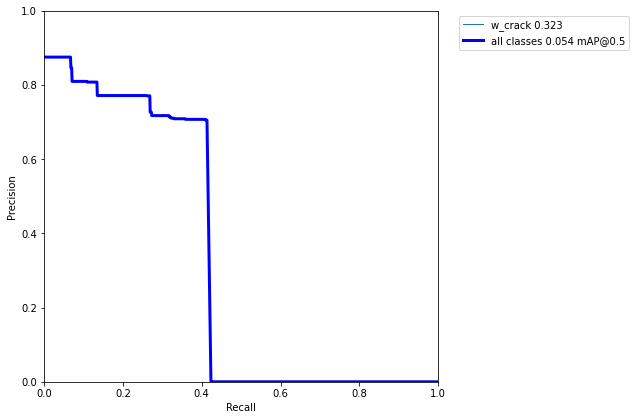

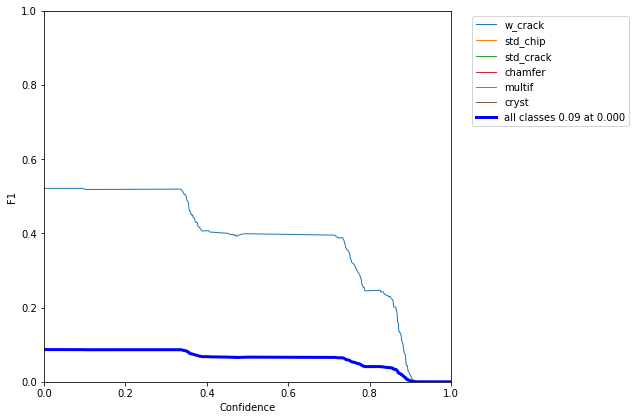

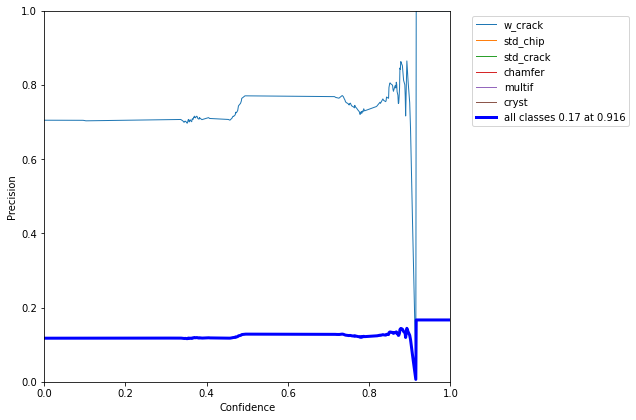

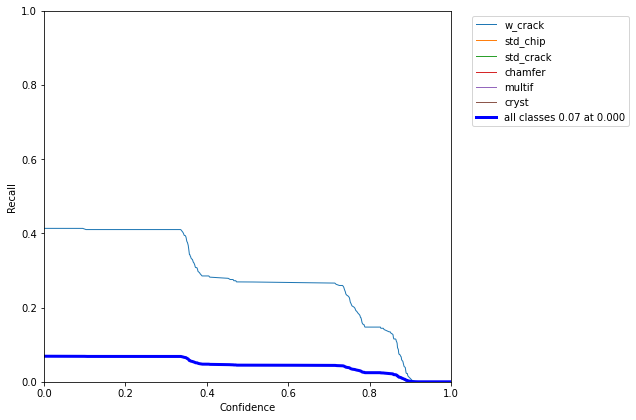

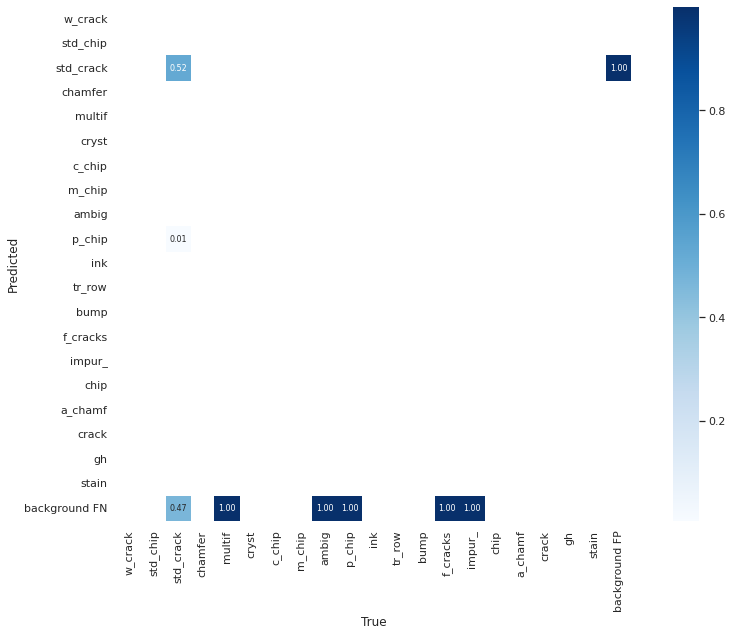

In [10]:
gt_lbl='dc-1/labels/train/'
gt_img='dc-1/images/train/'
wbf_lbl='output/labels/'
categories=['w_crack', 'std_chip', 'std_crack', 'chamfer', 'multif', 'cryst', 'c_chip', 'm_chip', 'ambig', 'p_chip', 'ink', 'tr_row', 'bump', 'f_cracks', 'impur_', 'chip', 'a_chamf', 'crack', 'gh', 'stain']

ap_class, seen, nt, p, r, ap50, ap = create_plots(gt_lbl,gt_img,wbf_lbl,categories)